In [19]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
CSV = '../../data/tira-annotated-metadata.csv'

In [3]:
df = pd.read_csv(CSV, keep_default_na=False)
df.head()

,,Filename,Duration,RA work complete,Annotation in ELAN,Annotations done(ish)?,Files uploaded to Kwaras?,Elicitation leader,Transcriber,Present,Category,Content,num_utterances,utterance_len_total,utterance_len_avg
0,7/31/2020,HH07312020-Audacity,0:54:11,,Sharon,yes,9/1/2020,Peter,Peter,"Nina, Sharon, Peter",Paradigms,"conjugation of 'fetch water' in perfective, im...",136,0:04:21,0:00:01
1,8/7/2020,HH08072020,1:10:50,,Nina,yes,9/2/2020,Nina,Sharon,"Nina, Sharon",Paradigms,"minimal pair for consonant quantity (one/any),...",288,0:10:24,0:00:02
2,8/14/2020,HH08142020,1:15:46,,Sharon,yes,9/3/2020,Nina/Sharon,Peter,"Nina, Sharon, Peter",Paradigms,"Good morning, subj/obj forms of water, worm, b...",108,0:03:46,0:00:02
3,8/21/2020,HH08212020-1,0:25:06,,Sharon,yes,9/10/2020,Sharon,Sharon,"Nina, Sharon",Phrases,"Subj/obj forms of person names (Kalu, Koko, Hi...",63,0:02:18,0:00:02
4,8/21/2020,HH08212020-2,0:38:03,,Nina,yes,09-03-2020 (v1); 01-25-2021 (v2),Nina,Sharon,"Nina, Sharon",Alphabet book,"Text on leopard (muzu) from Alphabet M book, s...",158,0:04:47,0:00:01


In [4]:
df['cat_list'] = df['Category']\
    .str.split('+')\
    .apply(lambda l: [s.strip().lower() for s in l])
    
df['cat_list'].astype(str).value_counts()

['paradigms']                     63
['syntax']                        18
['wordlists']                     12
['paradigms', 'story']             5
['alphabet book', 'paradigms']     5
['story', 'paradigms']             3
['tonal elicitation']              3
['alphabet book', 'syntax']        2
['alphabet book']                  2
['story', 'tonal elicitation']     2
['wordlists', 'syntax']            1
['phrases']                        1
['paradigms', 'syntax']            1
['story', 'syntax']                1
['paradigms', 'alphabet book']     1
['paradigms', 'phrases']           1
['story', 'wordlists']             1
Name: cat_list, dtype: int64

In [8]:
utterance_cats = defaultdict(lambda:0)
recording_cats = defaultdict(lambda:0)

def count_utterance_categories(row):
    cats = row['cat_list']
    num_utts = row['num_utterances']
    for cat in cats:
        utterance_cats[cat] += num_utts/len(cats)
        recording_cats[cat] += 1#/len(cats)

df.apply(count_utterance_categories, axis=1)
utterance_cats, recording_cats

(defaultdict(<function __main__.<lambda>()>,
             {'paradigms': 10326.0,
              'phrases': 162.0,
              'alphabet book': 852.0,
              'syntax': 1660.5,
              'story': 992.5,
              'wordlists': 2458.0,
              'tonal elicitation': 704.0}),
 defaultdict(<function __main__.<lambda>()>,
             {'paradigms': 79,
              'phrases': 2,
              'alphabet book': 10,
              'syntax': 23,
              'story': 12,
              'wordlists': 14,
              'tonal elicitation': 5}))

In [21]:
def count_cats_per_recording(row, cat):
    num_utts = row['num_utterances']
    cat_list = row['cat_list']
    if cat not in cat_list:
        return 0
    return num_utts / len(cat_list)

def softmax(x):
    return(np.exp(x)/np.exp(x).sum())

cats = list(utterance_cats.keys())
for cat in cats:
    df[cat] = softmax(df.apply(lambda row: count_cats_per_recording(row, cat), axis=1))

df[cats]

,paradigms,phrases,alphabet book,syntax,story,wordlists,tonal elicitation
0,2.514832e-67,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
1,2.589823e-01,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
2,1.738855e-79,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
3,2.169998e-126,2.319523e-16,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
4,2.169998e-126,1.011221e-43,1.798621e-02,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
...,...,...,...,...,...,...,...
117,1.188972e-48,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119
118,2.169998e-126,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.000000e+00
119,2.169998e-126,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,2.001470e-75
120,1.467308e-52,1.011221e-43,4.329239e-71,4.296027e-61,8.854772e-70,6.690503e-155,1.007655e-119


In [32]:
def make_balanced_split(df, splitsize=0.8):
    total_utterances = df['num_utterances'].sum()
    split_records = total_utterances*splitsize
    new_df = pd.DataFrame(columns=df.columns)

    size_by_cat = {cat: 0 for cat in cats}

    while len(new_df) < split_records:
        min_cat = min(size_by_cat, key=size_by_cat.get)
        has_cat = df['cat_list'].apply(lambda l: min_cat in l)
        new_row = df[has_cat].sample()
        new_df = pd.concat([new_df, pd.DataFrame(new_row)])
        df = df.drop(new_row.index)
    return new_df, df

make_balanced_split(df)


ValueError: a must be greater than 0 unless no samples are taken

In [29]:
df_copy = df.copy()
print(df_copy.shape)
sample = df_copy.sample()
df_copy = df_copy.drop(sample.index)
print(df_copy.shape)

(122, 23)
(121, 23)


In [33]:
cats

['paradigms',
 'phrases',
 'alphabet book',
 'syntax',
 'story',
 'wordlists',
 'tonal elicitation']

In [7]:
import yaml
import pandas as pd

In [4]:
SEGMENTS_YAML = '../../data/tira-speech-segments.yaml'

In [ ]:
with open(SEGMENTS_YAML) as f:
    segments = yaml.safe_load(f)

In [8]:
segments[:5]

[{'duration': 2.6599999999999966,
  'offset': 50.77,
  'speaker_id': 'HIM',
  'wav': 'G:\\Shared drives\\Tira\\Recordings\\2020-07-31-Tira\\HH07312020-Audacity.wav'},
 {'duration': 2.980000000000004,
  'offset': 56.235,
  'speaker_id': 'HIM',
  'wav': 'G:\\Shared drives\\Tira\\Recordings\\2020-07-31-Tira\\HH07312020-Audacity.wav'},
 {'duration': 2.1300000000000097,
  'offset': 62.55,
  'speaker_id': 'HIM',
  'wav': 'G:\\Shared drives\\Tira\\Recordings\\2020-07-31-Tira\\HH07312020-Audacity.wav'},
 {'duration': 1.5900000000000034,
  'offset': 87.78,
  'speaker_id': 'HIM',
  'wav': 'G:\\Shared drives\\Tira\\Recordings\\2020-07-31-Tira\\HH07312020-Audacity.wav'},
 {'duration': 2.490000000000009,
  'offset': 361.305,
  'speaker_id': 'HIM',
  'wav': 'G:\\Shared drives\\Tira\\Recordings\\2020-07-31-Tira\\HH07312020-Audacity.wav'}]

In [10]:
df = pd.DataFrame(data=segments)
df.head()

,duration,offset,speaker_id,wav
0,2.66,50.770,HIM,G:\Shared drives\Tira\Recordings\2020-07-31-Ti...
1,2.98,56.235,HIM,G:\Shared drives\Tira\Recordings\2020-07-31-Ti...
2,2.13,62.550,HIM,G:\Shared drives\Tira\Recordings\2020-07-31-Ti...
3,1.59,87.780,HIM,G:\Shared drives\Tira\Recordings\2020-07-31-Ti...
4,2.49,361.305,HIM,G:\Shared drives\Tira\Recordings\2020-07-31-Ti...


array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

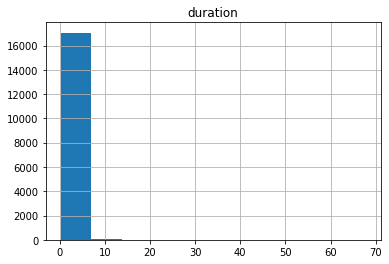

In [11]:
df.hist('duration')

In [12]:
df['duration'].max()

67.70900000000006

In [13]:
df['duration'].sort_values()

8165      0.240
13541     0.259
5479      0.260
7843      0.270
4958      0.275
          ...  
15152    13.578
11720    14.760
2697     20.180
2726     20.529
6549     67.709
Name: duration, Length: 17155, dtype: float64

In [21]:
len(df[df['duration']>3])/len(df)

0.11984844068784611

In [22]:
df['duration'].mean()

2.078451355290005

In [23]:
df['duration'].median()

1.887999999999991

In [25]:
df['duration'].quantile(0.95)

3.9606000000000208